In [15]:
import re

import numpy as np
import pandas as pd
import torch
import plotly.express as px
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)



In [16]:
# Load the local dataset

df = pd.read_csv("../data/phishing_site_urls.csv")
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [17]:
# Data Exploration

# plot bar graph of Categories
plotdf = df['Label'].value_counts()

fig = px.bar(plotdf,
             x=plotdf.index,
             y=plotdf.values,
             color=['lightblue', 'lightred'],
             labels={'x': 'Category', 'y': 'Count'},
             title='Categorical Distribution')

fig.show()

In [18]:
# Preprocessing 1 -- duplicate and NaN processsing
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})

df.dropna(inplace=True,axis=0)      # removes any row that contain missing values nan
df.drop_duplicates(inplace=True)    # removes duplicate row from the dataframe

df.head()


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [19]:
# Preprocessing, sample the datset to speed up training and normalize label disparity

import pandas as pd

# assume df has a column 'Label' with 0 and 1
n = 5000
# n = 100
df = pd.concat([
    df[df.Label == 0].sample(n, random_state=42),
    df[df.Label == 1].sample(n, random_state=42),
]).sample(frac=1, random_state=42).reset_index(drop=True)

df.count()

URL      10000
Label    10000
dtype: int64

In [20]:
# Preprocessing 2 -- clean urls

def clean_url(url):
    # Remove protocols
    url = re.sub(r'https?://', '', url)
    url = re.sub(r'www\.', '', url)

    # Lowercase
    url = url.lower()

    # Remove trailing slashes
    url = url.rstrip('/')

    # Optional: remove special characters except dots, slashes, and dashes
    url = re.sub(r'[^a-zA-Z0-9./\-]', '', url)
   
    return url

# Apply cleaning
df['URL'] = df['URL'].apply(clean_url)

# Preview cleaned data
print(df.head())

                                                 URL  Label
0                                rejtjel.hu/ya83t3xq      1
1         vitals.com/doctors/drcynthiawoodwhite.html      0
2  cimetierenotredamedesneiges.ca/en/research/fam...      0
3  marching-band.net/cgi-bin/bands/rate.cgiidwzkx...      0
4           songkick.com/artists/51417-patrick-fiori      0


In [21]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)


In [22]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["URL"],
                     truncation=True,
                     padding="max_length",
                     max_length=128)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test":  Dataset.from_pandas(test_df),
})

ds = ds.rename_column("Label", "labels")

ds = ds.map(tokenize, batched=True)
ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 2000/2000 [00:00<00:00, 42308.16 examples/s]


In [ ]:
# training device validation
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())
print("MPS built-in:", torch.backends.mps.is_built())

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


MPS available: True
MPS built-in: True
Using device: mps


In [24]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# speeds up training when GPUs are available
has_mps  = torch.backends.mps.is_available()
has_cuda = torch.cuda.is_available()

args = TrainingArguments(
    output_dir=f"./{model_name.replace('/', '_')}-out",
    num_train_epochs=1,
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,
    bf16=has_mps,
    fp16=has_cuda,
)

# 4. Trainer & run
trainer_distilbert = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer_distilbert.train()
print("Final results:", trainer_distilbert.evaluate())


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k9/gqghktb1187d9tphx4_lfjxc0000gn/T/ipykernel_27956/2910680754.py:23: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



Step,Training Loss


/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



Final results: {'eval_loss': 0.1476014107465744, 'eval_accuracy': 0.939, 'eval_runtime': 17.6595, 'eval_samples_per_second': 113.254, 'eval_steps_per_second': 1.812, 'epoch': 1.0}


accuracy from transformer: 93.90 %
f1 score from transformer: 93.95 %
classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1000
           1       0.93      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



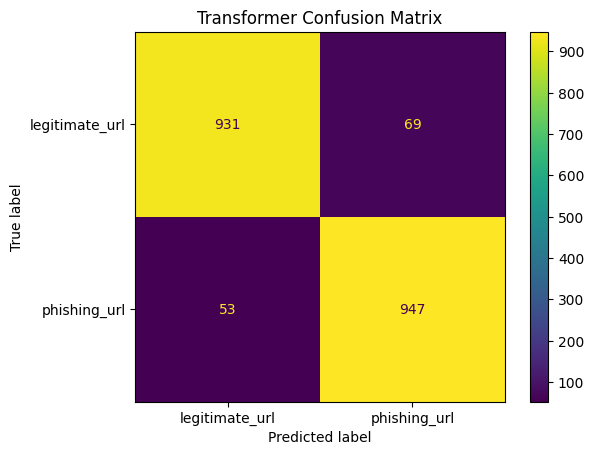

In [25]:
# Evaluate transformer model and plot confusion matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

pred_out = trainer_distilbert.predict(ds["test"])
preds = np.argmax(pred_out.predictions, axis=1)
labels = pred_out.label_ids

print(f"accuracy from transformer: {accuracy_score(labels, preds) * 100:.2f} %")
print(f"f1 score from transformer: {f1_score(labels, preds) * 100:.2f} %")
print("classification report:\n", classification_report(labels, preds))

cm = confusion_matrix(labels, preds, labels=[0, 1])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["legitimate_url", "phishing_url"]).plot()
plt.title("Transformer Confusion Matrix")
plt.show()


In [26]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

model_name = "google/electra-small-discriminator"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# speeds up training when GPUs are available
has_mps  = torch.backends.mps.is_available()
has_cuda = torch.cuda.is_available()

args = TrainingArguments(
    output_dir=f"./{model_name.replace('/', '_')}-out",
    num_train_epochs=2,
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,
    bf16=has_mps,
    fp16=has_cuda,
)

# 4. Trainer & run
trainer_electra = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer_electra.train()
print("Final results:", trainer_electra.evaluate())


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k9/gqghktb1187d9tphx4_lfjxc0000gn/T/ipykernel_27956/1032791414.py:23: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



Step,Training Loss
500,0.303100


/Users/briansterle/Library/Mobile Documents/com~apple~CloudDocs/compsci-masters/spring25/579_CyberThreatsAndDefense/final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



Final results: {'eval_loss': 0.19539962708950043, 'eval_accuracy': 0.9315, 'eval_runtime': 5.4724, 'eval_samples_per_second': 365.471, 'eval_steps_per_second': 5.848, 'epoch': 2.0}


accuracy from transformer: 93.15 %
f1 score from transformer: 93.22 %
classification report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1000
           1       0.92      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



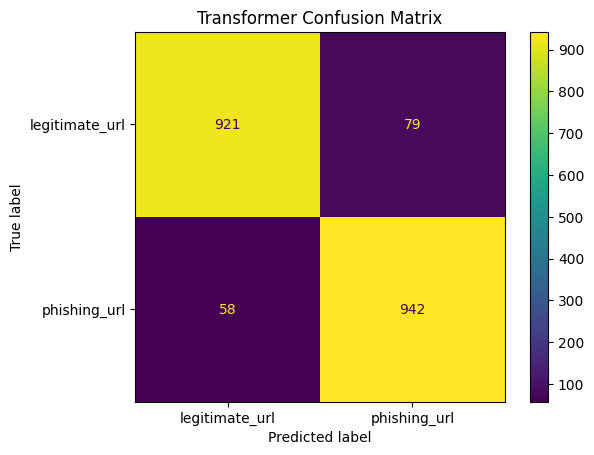

In [27]:
# Evaluate transformer model and plot confusion matrix
# 5. Evaluate each model using a held-out test set and optionally perform cross-validation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

pred_out = trainer_electra.predict(ds["test"])
preds = np.argmax(pred_out.predictions, axis=1)
labels = pred_out.label_ids

print(f"accuracy from transformer: {accuracy_score(labels, preds) * 100:.2f} %")
print(f"f1 score from transformer: {f1_score(labels, preds) * 100:.2f} %")
print("classification report:\n", classification_report(labels, preds))

cm = confusion_matrix(labels, preds, labels=[0, 1])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["legitimate_url", "phishing_url"]).plot()
plt.title("Transformer Confusion Matrix")
plt.show()


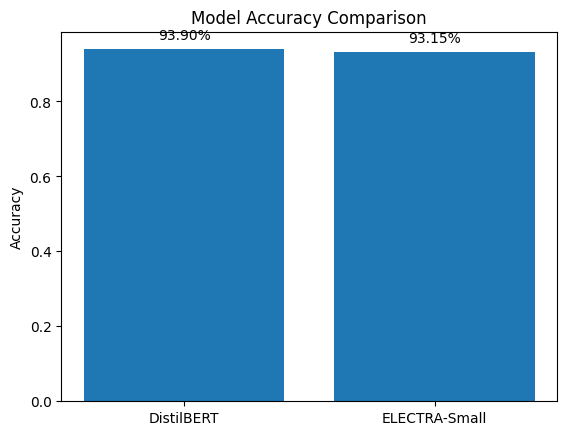

In [29]:
# Task 6: Accuracy Bar Chart

# get raw predictions on test set
preds_d = trainer_distilbert.predict(ds["test"])
y_true = preds_d.label_ids
y_pred_d = np.argmax(preds_d.predictions, axis=1)

preds_e = trainer_electra.predict(ds["test"])
y_pred_e = np.argmax(preds_e.predictions, axis=1)

acc_d = (y_pred_d == y_true).mean()
acc_e = (y_pred_e == y_true).mean()

bars = plt.bar(["DistilBERT", "ELECTRA-Small"], [acc_d, acc_e])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for bar in bars:
    h = bar.get_height()
    plt.annotate(f"{h:.2%}", xy=(bar.get_x() + bar.get_width()/2, h), xytext=(0, 5), textcoords="offset points", ha="center", va="bottom")
plt.show()

